In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdp_tut_functions as mdp
import env_functions as ef
from rl_utils import running_mean, discount_rwds, plot_reward_map
import agents as agts

# set seed for pseudorandom number generation -- make sure our trajectories look the same
np.random.seed(80)

%matplotlib inline

from importlib import reload

In [2]:
n_rows,n_cols = 16,16
step_penalization=-0.01

number_of_episodes = 5000
smoothing = int(number_of_episodes/100)

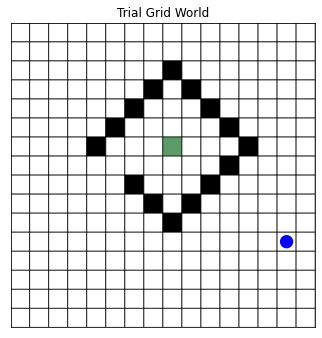

In [3]:
gw_obst = ef.GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(6,4),(5,5),(4,6),(3,7),(2,8),(3,9),(4,10),(5,11),(6,12),(7,11),(8,10),(9,9),(10,8),(9,9),(9,7),(8,6)], 
                  rewards={(6,8):10},
                  terminals=[(6,8)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False
                 )

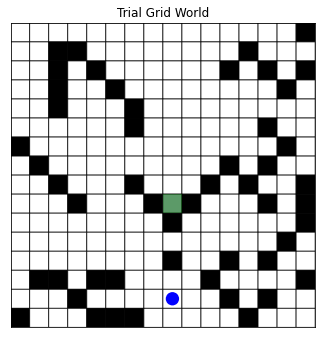

In [4]:
gw_rand_obst = ef.GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(4,2),(3,2),(2,2),(1,2),(1,3),(2,4),(3,5),(4,6),(5,6),(7,11),(8,10),(15,12),(9,9),(7,13),(10,8),(9,9),(9,7),(8,6),(13,1),(13,2),(12,8),(8,12),(9,13),(14,3),(12,11),(15,4),(13,15),(14,13),(13,10),(15,5),(15,4),(13,4),(13,5),(5,13),(6,14),(9,15),(10,15),(11,14),(12,13),(14,11),(12,11),(6,0),(7,1),(8,2),(9,3),(15,6),(8,15),(15,0),(0,15),(2,11),(1,12),(2,13),(3,14),(2,15),(13,4)], 
                  rewards={(9,8):10},
                  terminals=[(9,8)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False
                 )

Reward Function in Environment:


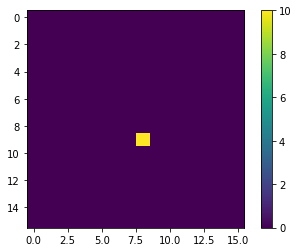

In [5]:
env = gw_rand_obst
print('Reward Function in Environment:')
plot_reward_map(env)

## Model-Free (Q Learning)Agent

Running Q-Learning Agent...
Done


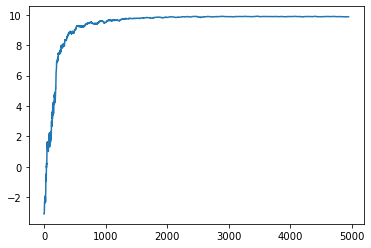

In [6]:
## run the Q learning agent through the environment 
modelfree  = agts.Q_Agent(env.nstates, env.nactions)
print('Running Q-Learning Agent...')
q_rewards,q_snapshot = modelfree.navigate(env, num_episodes=number_of_episodes)
print('Done')

plt.plot(running_mean(q_rewards,N=smoothing))
plt.show()



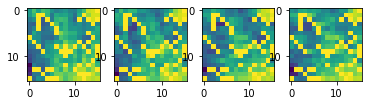

In [7]:
index = 20
fig, ax = plt.subplots(1,env.nactions)
for i in range(env.nactions):
    ax[i].imshow(q_snapshot[index][:,i].reshape(n_rows,n_cols))

## Model-Based (Dyna Q Learning) Agent

Running Q-Learning Agent...
Done


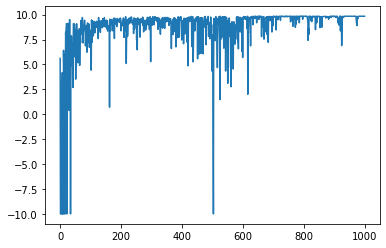

In [14]:
reload(agts)
modelbased=agts.Dyna_Q_Agent(env.nstates,env.nactions)
print('Running Q-Learning Agent...')
dyna_q_rewards,dyna_snapshot = modelbased.navigate(env,n_steps=5, num_episodes=1000)
print('Done')

plt.plot(dyna_q_rewards)
plt.show()

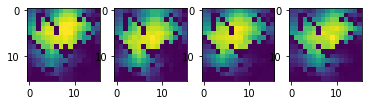

In [15]:
index = 20
fig, ax = plt.subplots(1,env.nactions)
for i in range(env.nactions):
    ax[i].imshow(dyna_snapshot[index][:,i].reshape(n_rows,n_cols))

## DATA EXPLORATION

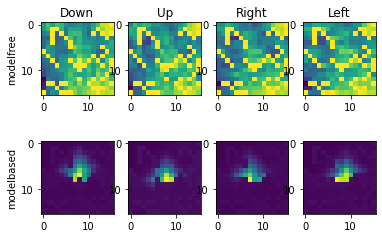

In [10]:
index = 20
fig, ax = plt.subplots(2,env.nactions)
for i in range(gw_obst.nactions):
    ax[0,i].imshow(q_snapshot[index][:,i].reshape(n_rows,n_cols))
    ax[1,i].imshow(dyna_snapshot[index][:,i].reshape(n_rows,n_cols))
    ax[0,i].set_title(env.action_list[i])

ax[0,0].set_ylabel('modelfree')#ax[1,0].set_ylabel('Q')
ax[1,0].set_ylabel('modelbased')
plt.show()

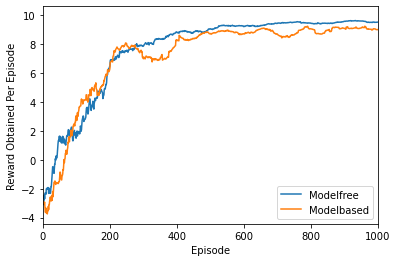

In [11]:
plt.plot(running_mean(q_rewards,smoothing), label='Modelfree')
plt.plot(running_mean(dyna_q_rewards,smoothing),label='Modelbased')
plt.legend(loc=0)
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.xlim(0,1000)
plt.show()